### Imports

In [7]:
#Standard Library
import random
import json
import math
import os
import re

#3rd Party Libraries
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import PIL
import pandas as pd
import scipy.stats

#Our library
from block_pipeline import *

jzazbz_array = np.load('../comp-syn2/notebooks/jzazbz_array.npy')

#Warning Supression for Pandas Performance
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

#Formatting
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config InlineBackend.rc = {'figure.facecolor': 'w'}

embedding_paths = {'JzAzBz_wavelet': 'block_stimuli_coeffs_jzazbz.txt',
                   'Grayscaled_wavelet': 'block_stimuli_coeffs_grey.txt',
                  'CNN': 'block_stimuli_resnet.json',
                  'Style': 'block_stimuli_style_vectors',
                  'Transformer': 'vt_emb_blocks.pickle'}

### Loading Data

In [2]:
# Load Dataframes of the Response Data and the Decoding CSV of Img URLs

#Set CSV Names
QualtricsCSV = 'Responses100.csv'
RandomizedPairingsCSV = 'SampleColorPairs.csv'

#Create DataFrames
Q_df = pd.read_csv(QualtricsCSV)
R_df = pd.read_csv(RandomizedPairingsCSV) #reference dataframe

#Print Shape
print('Shape of Qualtrics Data:', Q_df.shape)
print('Shape of Reference Data:', R_df.shape)

Shape of Qualtrics Data: (104, 621)
Shape of Reference Data: (200, 5)


### Trimming Data 

In [3]:
# Due to Qualtrics formatting the data must be cut out of the group rank column
#Misc Columns to Drop
drop_columns = ['StartDate','ProlificID', 'EndDate', 'Status', 'IPAddress', 'Progress', 
                      'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
                      'RecipientLastName', 'RecipientFirstName', 'RecipientEmail', 'ExternalReference',
                      'LocationLatitude', 'LocationLongitude', 'DistributionChannel', 'UserLanguage', 
                      'EmbeddedData', 'Create New Field or Choose From Dropdown...', 'Q3']

#Cut rank columns per question
rank_cut = ['{}_Q1_0_1_RANK'.format(x) for x in range(1,201)]
rank_cut_2 = ['{}_Q1_0_2_RANK'.format(x) for x in range(1,201)] 
drop_columns.extend(rank_cut)
drop_columns.extend(rank_cut_2)

#Drop the Columns
Q_df = Q_df.drop(columns=drop_columns)

#Remove the pesky 2nd header row
Q_df = Q_df.iloc[2: , :]

#Finally defragmenting the DataFrame for Performance
ogQ_df = Q_df.copy()

#Print the Dataframe: check for 200 questions.
print('Trimmed Data frame shape: ', Q_df.shape, '\n')
print(Q_df)

"""From onward, you can refer to the original data via ogQ_df"""

Trimmed Data frame shape:  (102, 200) 

    1_Q1_0_GROUP 2_Q1_0_GROUP 3_Q1_0_GROUP 4_Q1_0_GROUP 5_Q1_0_GROUP  \
2              2          NaN          NaN          NaN          NaN   
3            NaN          NaN          NaN          NaN          NaN   
4            NaN          NaN          NaN          NaN          NaN   
5              1          NaN            2          NaN          NaN   
6            NaN          NaN          NaN          NaN          NaN   
..           ...          ...          ...          ...          ...   
99           NaN          NaN          NaN          NaN          NaN   
100            1          NaN          NaN          NaN          NaN   
101            1            2          NaN          NaN          NaN   
102          NaN          NaN            1          NaN          NaN   
103          NaN          NaN          NaN            1          NaN   

    6_Q1_0_GROUP 7_Q1_0_GROUP 8_Q1_0_GROUP 9_Q1_0_GROUP 10_Q1_0_GROUP  ...  \
2            NaN 

'From onward, you can refer to the original data via ogQ_df'

### Translate Group Number to Rand Index

In [4]:
# We will now translate the values that are not nan into the rand index
#  of the corresponding question.

#Lamba Function to retrieve Rand Indexes from reference csv
def get_maxrand_index(x, q):
    
    response = 0
    if isinstance(x, str): #If a string and not nan
        if x == '1': #if 1, give filename
            response = int(R_df['FileName'][q][:-4])
        elif x == '2': #if 2, give associated pairing filename
            response = int(R_df['RandFile'][q][:-4])   
        else:
            response = 0
            
    return response

def get_minrand_index(x, q):
    
    response = 0
    if isinstance(x, str): #If a string and not nan
        if x == '1': #if 1, give filename
            response = int(R_df['RandFile'][q][:-4]) 
        elif x == '2': #if 2, give associated pairing filename  
            response = int(R_df['FileName'][q][:-4])
        else:
            response = 0
            
    return response

#Running a loop that references R_df (reference_dataframe) for the index
for q in range(0,Q_df.shape[1]):
    Q_df['Similar_Q{}'.format(q+1)] = Q_df['{}_Q1_0_GROUP'.format(q+1)].apply(lambda x: get_maxrand_index(x, q))
    Q_df['Different_Q{}'.format(q+1)] = Q_df['{}_Q1_0_GROUP'.format(q+1)].apply(lambda x: get_minrand_index(x, q))

In [5]:
# Apologies for the massive errors, but the current version of pandas has an unresolved bug with
#  format based column selection being percieved as fragmentation. 
#  Hopefully a contributer changes that soon

#Let us relock onto the relevant portion of the dataframe.
RandQ_df = Q_df.iloc[:, 200:]
print(np.unique(RandQ_df['Similar_Q1'], return_counts=True))

"""One can reach this dataframe at any time using RandQ_df"""

(array([     0, 103355, 491072]), array([90, 10,  2]))


'One can reach this dataframe at any time using RandQ_df'

### DataFrame Reference Text

    The RandQ_df dataframe provides two columns per question:
    The Similar Column shows which image the participant selected as similar
    The Different Column shows which image the participant selected as different
    
    *The Difference column is a mirror of the first, for ease of deducing matched
        image pairs!
    
    To deduce the total number of votes one can sum the answers that
    are not 0 in either of the columns.
    
    We will now export this dataframe as the defacto data to be analyzed.

### Saving the DF to CSV

In [6]:
RandQ_df.to_csv('ResponseIndex.csv')

### Retrieving the BenchMark ID's & Calculating Embeddings

To retrieve the benchmarks from the random set we need to calculate the cnn/wavlet embeddings and look for embeddings >= 0.5. First we need to retrive the embedding data.

In [8]:
block_data, block_data_stats = get_block_data(jzazbz_array)

minmax_dists = {}
img_names_in_order = {}

for key in embedding_paths.keys():
    minmax_dists[key], img_names_in_order[key] = get_block_embeddings(block_data,key,embedding_paths[key])

### Finding Benchmark IDs

In [9]:
# Using R_df we retrieve a list of rands. 

rand_column = R_df['FileName'].tolist()
rands = [int(i[:-4]) for i in rand_column]

print('Length of Rands: ', len(rands), '\n')
print(rands)

Length of Rands:  200 

[103355, 107450, 110268, 114352, 120151, 121958, 125657, 128148, 128391, 129473, 129981, 131932, 135230, 137337, 139182, 149503, 152617, 155576, 156542, 156730, 157164, 158823, 171829, 171836, 171890, 173416, 175203, 177247, 177789, 177804, 17955, 184779, 191335, 197775, 199041, 20056, 214176, 218126, 220884, 220984, 22671, 231915, 235167, 235362, 235796, 239931, 248710, 252764, 256840, 258795, 259178, 269536, 270936, 273538, 278167, 286103, 288790, 291999, 298356, 312252, 314877, 319030, 321879, 327069, 32711, 328947, 329365, 331236, 347449, 349457, 350605, 351279, 364167, 365838, 365871, 365890, 366326, 384681, 385777, 39081, 400573, 41090, 416880, 420571, 421909, 435564, 43585, 439792, 452366, 454351, 461243, 473254, 482690, 486232, 489492, 491072, 500186, 500328, 501108, 516349, 51663, 519332, 521430, 52528, 527035, 528178, 529036, 536226, 539439, 543176, 54886, 555839, 559042, 564685, 565894, 568550, 573665, 579879, 591723, 592673, 593128, 601661, 601863, 6

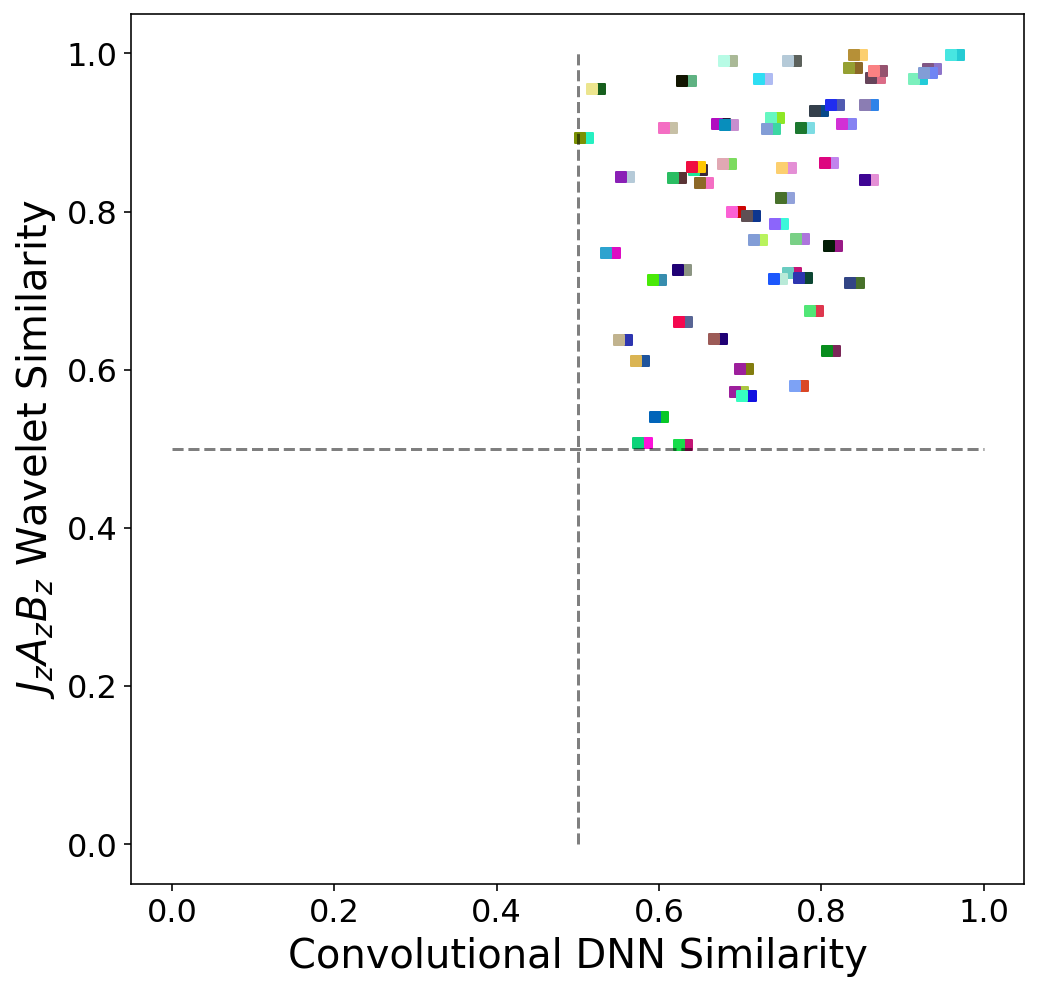

Length of Benchmark Set:  60
Benchmark Set:  [110268, 121958, 129981, 131932, 137337, 149503, 175203, 184779, 199041, 235796, 239931, 256840, 258795, 259178, 270936, 273538, 278167, 319030, 327069, 328947, 329365, 331236, 347449, 349457, 365838, 384681, 41090, 421909, 452366, 473254, 486232, 489492, 500186, 521430, 527035, 528178, 54886, 565894, 591723, 648143, 64820, 654811, 65725, 665987, 718315, 732180, 776997, 787201, 791743, 84654, 870910, 87498, 899159, 902648, 905778, 912756, 917040, 953277, 954698, 989436]


In [12]:
fig, ax = plt.subplots(figsize=(8,8))
benchmark_index = []

#Plot Pairs in 
for rand in rands:
    
    #ColorA
    a = minmax_dists['CNN'][block_data_stats['minmax_dists']>0.][rand]
    b = minmax_dists['JzAzBz_wavelet'][block_data_stats['minmax_dists']>0.][rand]
    
    #ColorB
    c = -0.01+minmax_dists['CNN'][block_data_stats['minmax_dists']>0.][rand]
    d = minmax_dists['JzAzBz_wavelet'][block_data_stats['minmax_dists']>0.][rand]
    
    color1 = np.array(block_data_stats['colors1']).reshape(1000000,3)[block_data_stats['minmax_dists']>0.][rand]/255.
    color2 = np.ravel(block_data_stats['colors2']).reshape(1000000,3)[block_data_stats['minmax_dists']>0.][rand]/255.
    
    #If CNN and Wavlet Embedding is > 0.5, then plot and add to benchmark index.
    if a > 0.5 and b > 0.5:
        ax.scatter(a,b, marker='s',s=30,alpha=1., color=color1)
        ax.scatter(c,d, marker='s',s=30,alpha=1., color=color2)
        
        benchmark_index.append(rand)
    
plt.plot(np.ones(10)*0.5,np.linspace(0.,1.,10),'k--',alpha=0.5)
plt.plot(np.linspace(0.,1.,10),np.ones(10)*0.5,'k--',alpha=0.5)

plt.xticks([0.,0.2,0.4,0.6,0.8,1.0],fontsize=16)
plt.yticks([0.,0.2,0.4,0.6,0.8,1.0],fontsize=16)

plt.xlabel(r'Convolutional DNN Similarity',fontsize=20)
plt.ylabel(r'$J_z A_z B_z$ Wavelet Similarity',fontsize=20)
plt.show()

print('Length of Benchmark Set: ', len(benchmark_index))
print('Benchmark Set: ', benchmark_index)

### Creating Embedding Dataframe & Mapping Embeddings

In [14]:
#Make Lists and apply all to the dataframe
cnn = []
style = []
transformer = []
wav = []
jzazbz = []
rgb = []
benchmark = []

# Retrieving Embeddings for every Rand Index Value
for rand in rands: 
    cnn_embed = minmax_dists['CNN'][block_data_stats['minmax_dists']>0.][rand]
    style_embed = minmax_dists['Style'][block_data_stats['minmax_dists']>0.][rand]
    transformer_embed = minmax_dists['Transformer'][block_data_stats['minmax_dists']>0.][rand]
    wav_embed = minmax_dists['JzAzBz_wavelet'][block_data_stats['minmax_dists']>0.][rand]
    jzazbz_embed = 1.-block_data_stats['minmax_dists'][block_data_stats['minmax_dists']>0.][rand]
    rgb_embed = 1.-block_data_stats['rgb_minmax_dists'][block_data_stats['minmax_dists']>0.][rand]
    
    bench = False
    if rand in benchmark_index:
        bench = True
        
    cnn.append(cnn_embed)
    style.append(style_embed)
    transformer.append(transformer_embed)
    wav.append(wav_embed)
    jzazbz.append(jzazbz_embed)
    rgb.append(rgb_embed)
    benchmark.append(bench)

In [15]:
#Getting Majority and Minority Votes for each pair from RandQ_df
vote_array = np.empty((200,4), dtype='int')

for q in range(0,200):
    
    #Sorted Array of Majority Voted Similar
    a = RandQ_df['Similar_Q{}'.format(q+1)].where(RandQ_df['Similar_Q{}'.format(q+1)]!=0).value_counts()
    
    #Sorted Array of Majority Voted Different (used to index in the case of 100% A votes.)
    b = RandQ_df['Different_Q{}'.format(q+1)].where(RandQ_df['Different_Q{}'.format(q+1)]!=0).value_counts()
    
    #total votes
    c = np.sum(a[:])
    
    #Array format: Index of majority similar, Votes, Index of Minority, Votes
    vote_array[q]= int(a.index[0]), a.iloc[0], b.index[0], (c-b.iloc[0])

print('Shape of vote array: ',vote_array.shape)
print(vote_array[:20])

Shape of vote array:  (200, 4)
[[103355     10 491072      2]
 [149503     16 107450      0]
 [110268      7  17955      5]
 [732180      6 114352      5]
 [120151     12 618992      1]
 [121958      6 568550      0]
 [349457      6 125657      2]
 [128148      4 791743      2]
 [128391      5 822352      3]
 [239931     12 129473      0]
 [129981     15 329365      0]
 [131932      7 889765      6]
 [764121     10 135230      6]
 [137337      8 385777      3]
 [912756     12 139182      2]
 [149503     15 858158      0]
 [288790      6 152617      1]
 [718315      3 155576      3]
 [416880      8 156542      4]
 [347449      8 156730      6]]


In [16]:

out = []
for pair in vote_array:
    major = int(np.where(rands == pair[0])[0])
    minor = int(np.where(rands == pair[2])[0])
    
    out.append([rands[major], pair[1], pair[2], pair[3], 
          cnn[major], cnn[minor],
          style[major], style[minor],
          transformer[major], transformer[minor],
          wav[major], wav[minor], 
          jzazbz[major], jzazbz[minor],
          rgb[major], rgb[minor],
          benchmark[major], benchmark[minor]])
    
    '''
    print(rands[major], pair[1], pair[2], pair[3], 
          cnn[major], cnn[minor],
          style[major], style[minor],
          transformer[major], transformer[minor],
          wav[major], wav[minor], 
          jzazbz[major], jzazbz[minor],
          rgb[major], rgb[minor],
          benchmark[major], benchmark[minor]
         )'''
    

In [17]:
# One Frame to rule them all, One Frame to find them, One Frame to bring them all, and in the notebook bind them
TheOneFrame = pd.DataFrame(out, columns = [
                            'RandSimilar',  'MajorityVote',
                            'RandDifferent', 'MinorityVote',
                            'MajorCNN', 'MinorCNN',
                            'MajorStyle', 'MinorStyle',
                            'MajorTransformer', 'MinorTransformer',
                            'MajorWavelet', 'MinorWavelet',
                            'MajorJzAzBz', 'MinorJzAzBz',
                            'MajorRGB', 'MinorRGB',
                            'MajorIsBenchmark','MinorIsBenchmark'
                           ]) 

print(TheOneFrame)
TheOneFrame.to_csv('TheOneFrame.csv')

     RandSimilar  MajorityVote  RandDifferent  MinorityVote  MajorCNN  \
0         103355            10         491072             2  0.442575   
1         149503            16         107450             0  0.727279   
2         110268             7          17955             5  0.710107   
3         732180             6         114352             5  0.632895   
4         120151            12         618992             1  0.285419   
..           ...           ...            ...           ...       ...   
195       969587             8         529036             6  0.412947   
196       139182             9         973324             6  0.666255   
197       978217             4         482690             2  0.294154   
198       873332             7         989436             4  0.554749   
199       521430            14         990198             0  0.969299   

     MinorCNN  MajorStyle  MinorStyle  MajorTransformer  MinorTransformer  \
0    0.398159    0.506731    0.705181         

In [18]:
benchmark_test = 0.

for i in range(len(TheOneFrame)):
    if np.logical_and(TheOneFrame['MajorIsBenchmark'].values[i] == True,
                     TheOneFrame['MinorIsBenchmark'].values[i] == True):
        benchmark_test += 1

In [19]:
benchmark_test

16.0

### Majority/minority statistics

In [25]:
all_num = 0.
JzAzBz_agree = 0.
RGB_agree = 0.

all_num_benchmark = 0.
JzAzBz_agree_benchmark = 0.
RGB_agree_benchmark = 0.

jzazbz_failed_array = np.zeros(len(TheOneFrame))

for i in range(len(TheOneFrame)):
    if np.logical_or(TheOneFrame['MajorIsBenchmark'].values[i] == True,
                     TheOneFrame['MinorIsBenchmark'].values[i] == True):
        if TheOneFrame['MajorJzAzBz'].values[i] > TheOneFrame['MinorJzAzBz'].values[i]:
            JzAzBz_agree_benchmark += 1#TheOneFrame['VotesForMajority'].values[i]
            JzAzBz_failed_benchmark = False
        else:
            JzAzBz_agree_benchmark += 0#TheOneFrame['TotalVotes'].values[i] - TheOneFrame['VotesForMajority'].values[i]
            JzAzBz_failed_benchmark = True
        if TheOneFrame['MajorRGB'].values[i] > TheOneFrame['MinorRGB'].values[i]:
            RGB_agree_benchmark += 1#TheOneFrame['VotesForMajority'].values[i]
#             if JzAzBz_failed_benchmark == True:
#                 print('JzAzBz Failed_benchmark:', TheOneFrame['RandSimilar'].values[i],TheOneFrame['RandDifferent'].values[i])
#                 jzazbz_failed_array[i] = 1
        else:
            RGB_agree_benchmark += 0#TheOneFrame['TotalVotes'].values[i] - TheOneFrame['VotesForMajority'].values[i]
#             if JzAzBz_failed_benchmark == False:
#                 print('RGB Failed_benchmark:', TheOneFrame['RandSimilar'].values[i],TheOneFrame['RandDifferent'].values[i])
        all_num_benchmark += 1#TheOneFrame['TotalVotes'].values[i]
    else:
        if TheOneFrame['MajorJzAzBz'].values[i] > TheOneFrame['MinorJzAzBz'].values[i]:
            JzAzBz_agree += 1#TheOneFrame['VotesForMajority'].values[i]
            JzAzBz_failed = False
        else:
            JzAzBz_agree += 0#TheOneFrame['TotalVotes'].values[i] - TheOneFrame['VotesForMajority'].values[i]
            JzAzBz_failed = True
        if TheOneFrame['MajorRGB'].values[i] > TheOneFrame['MinorRGB'].values[i]:
            RGB_agree += 1#TheOneFrame['VotesForMajority'].values[i]
#             if JzAzBz_failed == True:
#                 print('JzAzBz Failed:', TheOneFrame['RandSimilar'].values[i],TheOneFrame['RandDifferent'].values[i])
#                 jzazbz_failed_array[i] = 1
        else:
            RGB_agree += 0#TheOneFrame['TotalVotes'].values[i] - TheOneFrame['VotesForMajority'].values[i]
#             if JzAzBz_failed == False:
#                 print('RGB Failed:', TheOneFrame['RandSimilar'].values[i],TheOneFrame['RandDifferent'].values[i])
        all_num += 1#TheOneFrame['TotalVotes'].values[i]
    

In [26]:
print(JzAzBz_agree/(1.*all_num))
print(RGB_agree/(1.*all_num))

# print(JzAzBz_agree_benchmark/(1.*all_num_benchmark))
# print(RGB_agree_benchmark/(1.*all_num_benchmark))

print(all_num)
# print(all_num_benchmark)

0.6979166666666666
0.71875
96.0


In [27]:
all_num = 0.
cnn_agree = 0.
wavelet_agree = 0.

all_num_benchmark = 0.
cnn_agree_benchmark = 0.
wavelet_agree_benchmark = 0.

cnn_failed_array = np.zeros(len(TheOneFrame))
wavelet_failed_array = np.zeros(len(TheOneFrame))

for i in range(len(TheOneFrame)):
    if np.logical_or(TheOneFrame['MajorIsBenchmark'].values[i] == True,
                     TheOneFrame['MinorIsBenchmark'].values[i] == True):
        if TheOneFrame['MajorCNN'].values[i] > TheOneFrame['MinorCNN'].values[i]:
            cnn_agree_benchmark += 1#TheOneFrame['VotesForMajority'].values[i]
            cnn_failed_benchmark = False
        else:
            cnn_agree_benchmark += 0#TheOneFrame['TotalVotes'].values[i] - TheOneFrame['VotesForMajority'].values[i]
            cnn_failed_benchmark = True
        if TheOneFrame['MajorWavelet'].values[i] > TheOneFrame['MinorWavelet'].values[i]:
            wavelet_agree_benchmark += 1#TheOneFrame['VotesForMajority'].values[i]
            if cnn_failed_benchmark == True:
#                 print('CNN Failed_benchmark:', TheOneFrame['RandSimilar'].values[i],TheOneFrame['RandDifferent'].values[i])
                cnn_failed_array[i] = 1
        else:
            wavelet_agree_benchmark += 0#TheOneFrame['TotalVotes'].values[i] - TheOneFrame['VotesForMajority'].values[i]
            if cnn_failed_benchmark == False:
                print('Wavelet Failed_benchmark:', TheOneFrame['RandSimilar'].values[i],TheOneFrame['RandDifferent'].values[i])
                wavelet_failed_array[i] = 1
        all_num_benchmark += 1#TheOneFrame['TotalVotes'].values[i]
    else:
        if TheOneFrame['MajorCNN'].values[i] > TheOneFrame['MinorCNN'].values[i]:
            cnn_agree += 1#TheOneFrame['VotesForMajority'].values[i]
            cnn_failed = False
        else:
            cnn_agree += 0#TheOneFrame['TotalVotes'].values[i] - TheOneFrame['VotesForMajority'].values[i]
            cnn_failed = True
        if TheOneFrame['MajorWavelet'].values[i] > TheOneFrame['MinorWavelet'].values[i]:
            wavelet_agree += 1#TheOneFrame['VotesForMajority'].values[i]
            if cnn_failed == True:
#                 print('CNN Failed:', TheOneFrame['RandSimilar'].values[i],TheOneFrame['RandDifferent'].values[i])
                cnn_failed_array[i] = 1
        else:
            wavelet_agree += 0#TheOneFrame['TotalVotes'].values[i] - TheOneFrame['VotesForMajority'].values[i]
            if cnn_failed == False:
#                 print('Wavelet Failed:', TheOneFrame['RandSimilar'].values[i],TheOneFrame['RandDifferent'].values[i])
                wavelet_failed_array[i] = 1
        all_num += 1#TheOneFrame['TotalVotes'].values[i]
    

Wavelet Failed_benchmark: 149503 107450
Wavelet Failed_benchmark: 349457 125657
Wavelet Failed_benchmark: 137337 385777
Wavelet Failed_benchmark: 718315 155576
Wavelet Failed_benchmark: 235796 601863
Wavelet Failed_benchmark: 286103 365838
Wavelet Failed_benchmark: 235167 329365
Wavelet Failed_benchmark: 384681 41090
Wavelet Failed_benchmark: 452366 941218
Wavelet Failed_benchmark: 235796 579879
Wavelet Failed_benchmark: 591723 755073
Wavelet Failed_benchmark: 627438 489492
Wavelet Failed_benchmark: 528178 64820
Wavelet Failed_benchmark: 870910 65725
Wavelet Failed_benchmark: 137337 721772
Wavelet Failed_benchmark: 732180 155576
Wavelet Failed_benchmark: 256840 791743
Wavelet Failed_benchmark: 912756 516349
Wavelet Failed_benchmark: 954698 918232


In [28]:
print(cnn_agree/(1.*all_num))
print(wavelet_agree/(1.*all_num))

print(cnn_agree_benchmark/(1.*all_num_benchmark))
print(wavelet_agree_benchmark/(1.*all_num_benchmark))

print((cnn_agree+cnn_agree_benchmark)/(1.*(all_num+all_num_benchmark)))
print((wavelet_agree+wavelet_agree_benchmark)/(1.*(all_num+all_num_benchmark)))

print(all_num)
print(all_num_benchmark)

0.40625
0.6666666666666666
0.7115384615384616
0.75
0.565
0.71
96.0
104.0


In [29]:
ind = np.logical_or(TheOneFrame['MajorIsBenchmark'].values == True,
                     TheOneFrame['MinorIsBenchmark'].values == True)

print(scipy.stats.spearmanr(TheOneFrame['MajorityVote'].values[ind==False]/(TheOneFrame['MajorityVote'].values[ind==False]+TheOneFrame['MinorityVote'].values[ind==False]),
            TheOneFrame['MajorWavelet'].values[ind==False]-TheOneFrame['MinorWavelet'].values[ind==False]))

print(scipy.stats.spearmanr(TheOneFrame['MajorityVote'].values[ind==False]/(TheOneFrame['MajorityVote'].values[ind==False]+TheOneFrame['MinorityVote'].values[ind==False]),
            TheOneFrame['MajorCNN'].values[ind==False]-TheOneFrame['MinorCNN'].values[ind==False]))

SpearmanrResult(correlation=0.3848891594462436, pvalue=0.00010794551022299552)
SpearmanrResult(correlation=-0.2139977752722033, pvalue=0.03629618786605138)


In [30]:
ind = np.logical_or(TheOneFrame['MajorIsBenchmark'].values == True,
                     TheOneFrame['MinorIsBenchmark'].values == True)

print(scipy.stats.spearmanr(TheOneFrame['MajorityVote'].values[ind==False]/(TheOneFrame['MajorityVote'].values[ind==False]+TheOneFrame['MinorityVote'].values[ind==False]),
            TheOneFrame['MajorStyle'].values[ind==False]-TheOneFrame['MinorStyle'].values[ind==False]))

print(scipy.stats.spearmanr(TheOneFrame['MajorityVote'].values[ind==False]/(TheOneFrame['MajorityVote'].values[ind==False]+TheOneFrame['MinorityVote'].values[ind==False]),
            TheOneFrame['MajorTransformer'].values[ind==False]-TheOneFrame['MinorTransformer'].values[ind==False]))

SpearmanrResult(correlation=0.1678230237368167, pvalue=0.10217544454395489)
SpearmanrResult(correlation=0.008967487030027298, pvalue=0.9308989770927456)


### Plot

In [31]:
x = TheOneFrame['MajorityVote'].values[ind==False]/(TheOneFrame['MajorityVote'].values[ind==False]+TheOneFrame['MinorityVote'].values[ind==False])

y_wavelet = TheOneFrame['MajorWavelet'].values[ind==False]-TheOneFrame['MinorWavelet'].values[ind==False]

y_wavelet_bins = []
y_wavelet_bins.append(np.mean(y_wavelet[np.logical_and(x>=0.5,x<0.6)]))
y_wavelet_bins.append(np.mean(y_wavelet[np.logical_and(x>=0.6,x<0.7)]))
y_wavelet_bins.append(np.mean(y_wavelet[np.logical_and(x>=0.7,x<0.8)]))
y_wavelet_bins.append(np.mean(y_wavelet[np.logical_and(x>=0.8,x<0.9)]))
y_wavelet_bins.append(np.mean(y_wavelet[np.logical_and(x>=0.9,x<=1.0)]))

y_wavelet_bins = np.array(y_wavelet_bins)

y_wavelet_bins_std = []
y_wavelet_bins_std.append(np.std(y_wavelet[np.logical_and(x>=0.5,x<0.6)]))
y_wavelet_bins_std.append(np.std(y_wavelet[np.logical_and(x>=0.6,x<0.7)]))
y_wavelet_bins_std.append(np.std(y_wavelet[np.logical_and(x>=0.7,x<0.8)]))
y_wavelet_bins_std.append(np.std(y_wavelet[np.logical_and(x>=0.8,x<0.9)]))
y_wavelet_bins_std.append(np.std(y_wavelet[np.logical_and(x>=0.9,x<=1.0)]))

y_wavelet_bins_std = np.array(y_wavelet_bins_std)

In [32]:
x = TheOneFrame['MajorityVote'].values[ind==False]/(TheOneFrame['MajorityVote'].values[ind==False]+TheOneFrame['MinorityVote'].values[ind==False])

y_CNN = TheOneFrame['MajorCNN'].values[ind==False]-TheOneFrame['MinorCNN'].values[ind==False]

y_CNN_bins = []
y_CNN_bins.append(np.mean(y_CNN[np.logical_and(x>=0.5,x<0.6)]))
y_CNN_bins.append(np.mean(y_CNN[np.logical_and(x>=0.6,x<0.7)]))
y_CNN_bins.append(np.mean(y_CNN[np.logical_and(x>=0.7,x<0.8)]))
y_CNN_bins.append(np.mean(y_CNN[np.logical_and(x>=0.8,x<0.9)]))
y_CNN_bins.append(np.mean(y_CNN[np.logical_and(x>=0.9,x<=1.0)]))

y_CNN_bins = np.array(y_CNN_bins)

y_CNN_bins_std = []
y_CNN_bins_std.append(np.std(y_CNN[np.logical_and(x>=0.5,x<0.6)]))
y_CNN_bins_std.append(np.std(y_CNN[np.logical_and(x>=0.6,x<0.7)]))
y_CNN_bins_std.append(np.std(y_CNN[np.logical_and(x>=0.7,x<0.8)]))
y_CNN_bins_std.append(np.std(y_CNN[np.logical_and(x>=0.8,x<0.9)]))
y_CNN_bins_std.append(np.std(y_CNN[np.logical_and(x>=0.9,x<=1.0)]))

y_CNN_bins_std = np.array(y_CNN_bins_std)

In [33]:
x = TheOneFrame['MajorityVote'].values[ind==False]/(TheOneFrame['MajorityVote'].values[ind==False]+TheOneFrame['MinorityVote'].values[ind==False])

y_style = TheOneFrame['MajorStyle'].values[ind==False]-TheOneFrame['MinorStyle'].values[ind==False]

y_style_bins = []
y_style_bins.append(np.mean(y_style[np.logical_and(x>=0.5,x<0.6)]))
y_style_bins.append(np.mean(y_style[np.logical_and(x>=0.6,x<0.7)]))
y_style_bins.append(np.mean(y_style[np.logical_and(x>=0.7,x<0.8)]))
y_style_bins.append(np.mean(y_style[np.logical_and(x>=0.8,x<0.9)]))
y_style_bins.append(np.mean(y_style[np.logical_and(x>=0.9,x<=1.0)]))

y_style_bins = np.array(y_style_bins)

y_style_bins_std = []
y_style_bins_std.append(np.std(y_style[np.logical_and(x>=0.5,x<0.6)]))
y_style_bins_std.append(np.std(y_style[np.logical_and(x>=0.6,x<0.7)]))
y_style_bins_std.append(np.std(y_style[np.logical_and(x>=0.7,x<0.8)]))
y_style_bins_std.append(np.std(y_style[np.logical_and(x>=0.8,x<0.9)]))
y_style_bins_std.append(np.std(y_style[np.logical_and(x>=0.9,x<=1.0)]))

y_style_bins_std = np.array(y_style_bins_std)

In [34]:
x = TheOneFrame['MajorityVote'].values[ind==False]/(TheOneFrame['MajorityVote'].values[ind==False]+TheOneFrame['MinorityVote'].values[ind==False])

y_transformer = TheOneFrame['MajorTransformer'].values[ind==False]-TheOneFrame['MinorTransformer'].values[ind==False]

y_transformer_bins = []
y_transformer_bins.append(np.mean(y_transformer[np.logical_and(x>=0.5,x<0.6)]))
y_transformer_bins.append(np.mean(y_transformer[np.logical_and(x>=0.6,x<0.7)]))
y_transformer_bins.append(np.mean(y_transformer[np.logical_and(x>=0.7,x<0.8)]))
y_transformer_bins.append(np.mean(y_transformer[np.logical_and(x>=0.8,x<0.9)]))
y_transformer_bins.append(np.mean(y_transformer[np.logical_and(x>=0.9,x<=1.0)]))

y_transformer_bins = np.array(y_transformer_bins)

y_transformer_bins_std = []
y_transformer_bins_std.append(np.std(y_transformer[np.logical_and(x>=0.5,x<0.6)]))
y_transformer_bins_std.append(np.std(y_transformer[np.logical_and(x>=0.6,x<0.7)]))
y_transformer_bins_std.append(np.std(y_transformer[np.logical_and(x>=0.7,x<0.8)]))
y_transformer_bins_std.append(np.std(y_transformer[np.logical_and(x>=0.8,x<0.9)]))
y_transformer_bins_std.append(np.std(y_transformer[np.logical_and(x>=0.9,x<=1.0)]))

y_transformer_bins_std = np.array(y_transformer_bins_std)

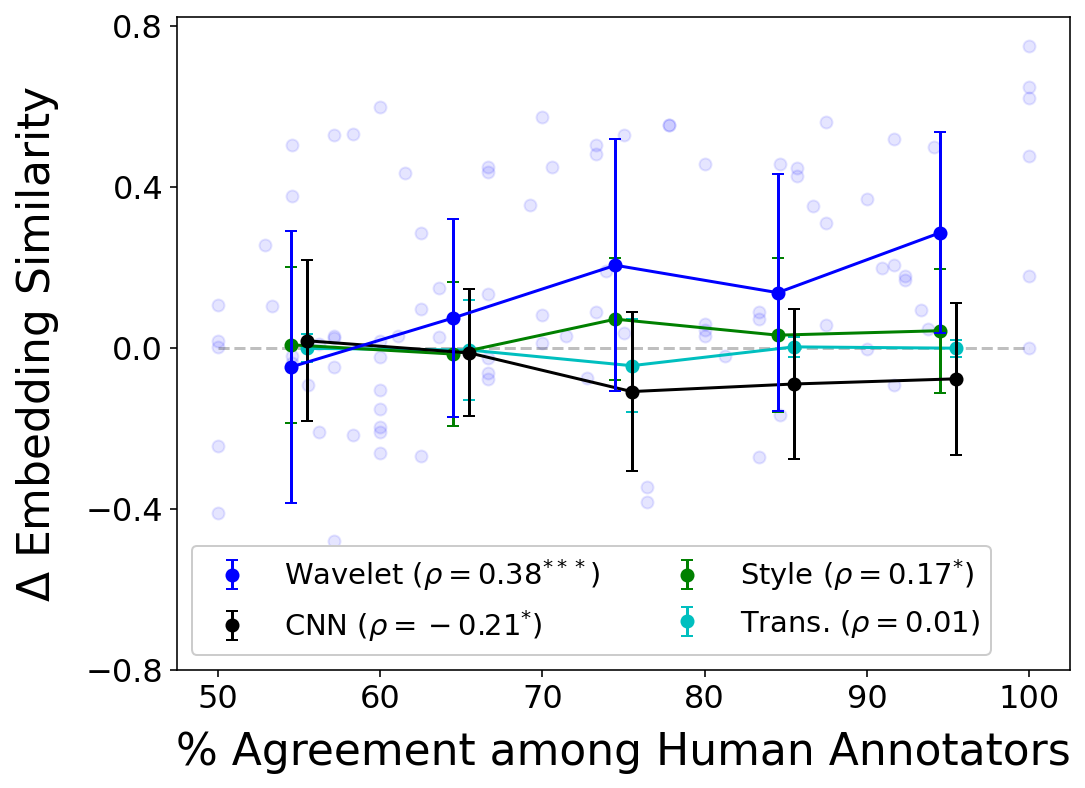

In [35]:
plt.figure(figsize=(8,6))

plt.scatter(TheOneFrame['MajorityVote'].values[ind==False]/(TheOneFrame['MajorityVote'].values[ind==False]+TheOneFrame['MinorityVote'].values[ind==False]),
            TheOneFrame['MajorWavelet'].values[ind==False]-TheOneFrame['MinorWavelet'].values[ind==False],#,label='Wavelet',
           alpha=0.1,c='b')

# plt.scatter(TheOneFrame['MajorityVote'].values[ind==False]/(TheOneFrame['MajorityVote'].values[ind==False]+TheOneFrame['MinorityVote'].values[ind==False]),
#             TheOneFrame['MajorCNN'].values[ind==False]-TheOneFrame['MinorCNN'].values[ind==False],#,label='Convolutional DNN',
#            alpha=0.1,c='k')

plt.plot(np.linspace(0.5,1.0,10),0.0*np.ones(10),'k--',alpha=0.25)

plt.plot([0.545,0.645,0.745,0.845,0.945],y_wavelet_bins,c='b',zorder=999)
plt.plot([0.555,0.655,0.755,0.855,0.955],y_CNN_bins,c='k',zorder=998)
plt.plot([0.545,0.645,0.745,0.845,0.945],y_style_bins,c='g',zorder=997)
plt.plot([0.555,0.655,0.755,0.855,0.955],y_transformer_bins,c='c',zorder=996)


plt.errorbar([0.545,0.645,0.745,0.845,0.945],y_wavelet_bins,yerr=y_wavelet_bins_std,fmt='o', capsize=3,
             label=r'Wavelet ($\rho=0.38^{***}$)',c='b',zorder=999)
plt.errorbar([0.555,0.655,0.755,0.855,0.955],y_CNN_bins,yerr=y_CNN_bins_std,fmt='o', capsize=3,
             label=r'CNN ($\rho=-0.21^{*}$)',c='k',zorder=998)
plt.errorbar([0.545,0.645,0.745,0.845,0.945],y_style_bins,yerr=y_style_bins_std,fmt='o', capsize=3,
             label=r'Style ($\rho=0.17^{*}$)',c='g',zorder=997)
plt.errorbar([0.555,0.655,0.755,0.855,0.955],y_transformer_bins,yerr=y_transformer_bins_std,fmt='o', capsize=3,
             label=r'Trans. ($\rho=0.01$)',c='c',zorder=996)


# plt.scatter(TheOneFrame['MinorityVote'].values[ind==False]/(TheOneFrame['MajorityVote'].values[ind==False]+TheOneFrame['MinorityVote'].values[ind==False]),
#             TheOneFrame['MinorCNN'].values[ind==False],label='Minority')

plt.xticks([0.5,0.6,0.7,0.8,0.9,1.0],[50,60,70,80,90,100],fontsize=16)
plt.yticks([-0.8,-0.4,0.0,0.4,0.8],fontsize=16)

plt.xlabel(r'% Agreement among Human Annotators',fontsize=22,labelpad=8)
plt.ylabel(r'$\Delta$ Embedding Similarity',fontsize=22,labelpad=12)
plt.legend(loc=3,fontsize=14.5,framealpha=1.0,ncol=2)

plt.show()